<a href="https://colab.research.google.com/github/aCStandke/ReinforcementLearning/blob/main/Experimental_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Importing the OpenAI Gym environment for Super Mario Bros

That plays on the Nintendo entertainment System(NES) through a nes-py emulator.

By default, gym_super_mario_bros 
environments use the full NES action space of 256 discrete actions. To contstrain this, gym_super_mario_bros.actions provides three actions lists (RIGHT_ONLY, SIMPLE_MOVEMENT, and COMPLEX_MOVEMENT) for the nes_py.wrappers.JoypadSpace wrapper. See gym_super_mario_bros/actions.py for a breakdown of the legal actions in each of these three lists.



---


Citation: 
@misc{gym-super-mario-bros,
  author = {Christian Kauten},
  howpublished = {GitHub},
  title = {{S}uper {M}ario {B}ros for {O}pen{AI} {G}ym},
  URL = {https://github.com/Kautenja/gym-super-mario-bros},
  year = {2018},
}



In [ ]:
!python3 -m pip install gym-super-mario-bros==7.3.0
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

from pyvirtualdisplay import Display

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.


In [ ]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

# TRAIN A MARIO-PLAYING RL AGENT
Orinial Authors: Yuansong Feng, Suraj Subramanian, Howard Wang, Steven Guo.

This was a tutorial made from the orginal authours that walks through the fundamentals of Deep Reinforcement Learning.

1.   See https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html for more details regarding implementation and results



In [ ]:
# Installing the required libraries
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, copy
from IPython import display as ipythondisplay
import time, datetime
import pickle
from tqdm import tqdm
import glob
import io
import base64
from IPython.display import HTML



# Installing Gym an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack
from gym.wrappers import Monitor

# Installing NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Installing Super Mario environment for OpenAI Gym
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT, RIGHT_ONLY


# Functions to Display Mario play the game:
These functions use the display backend of the python virtural environment to record mario in the enviorment by wrapping Mario's environment in the function wrap_env() which uses OpenAI's gym Monitor wrapper to record Mario in the env when render is called. The fuction show_video() displays the video using ipythondisplay.display in HTML form using the <video> tag on the colab server. 



*   See this notebook by  Jeff Heaton:  https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_01_ai_gym.ipynb#scrollTo=T9RpF49oOsZj for more information on rendering Open AI games



In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# Initialize the Mario enviornment

The mario environment is intialized using the method make(). 



In [ ]:
# Initialize Super Mario environment
env = wrap_env(gym_super_mario_bros.make("SuperMarioBros-1-1-v0"))

# Preprocessing the Environment

Since alot of the environmental information is not necessary(ie., color), Wrappers are used to preprocess the environment data before sending it to the agent/Mario. 



1.   **SkipFrame Class:**
  *   This wrapper inherits from the gym.Wrapper and implements the step() function. Because consecutive frames don’t vary much, we can skip n-intermediate frames without losing much information. The n-th frame aggregates rewards accumulated over each skipped frame.

2.   **FrameStack Class:**
  *   Is a wrapper that allows us to squash consecutive frames of the environment into a single observation point to feed to our learning model. This way, we can identify if Mario was landing or jumping based on the direction of his movement in the previous several frames. 

3.   **GrayScaleObservation and ResizeObservation Classes**
  *   These wrappers inherit from the gym.ObservationWrapper to first transform an RGB image to grayscale so that one color channel is used. Then the image is downsampled for each observation into a square image

4.  **JoypadSpace**
 *   Because the orginal Mario action space consists of 256 discrete actions, the number of actions that Mario can take is limited by setting the JoypadSpace wrapper to RIGHT_ONLY





In [ ]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)
# Using the RIGHT_ONLY action list for Mario in the environment
env = JoypadSpace(env, RIGHT_ONLY)

# Creating the Mario Agent

The Mario Agent should be able to do the following things:

1.   **ACT:** Mario should be able to take the most optimal action policy based on the current state of the environment
2.   **Remember:** Mario should be able to remember his past actions, to update his action policy. In this case Experience/Memory for Mario =(current state, current action, reward, next state). This is implemented through caching and later recalling his experiences
3.   **Learn:** Mario should learn a better action policy overtime 



---

# Act

For any given state, Mario can choose to do the most optimal action(called exploit) or a random action(called explore). When Mario chooses to randomly explore this chance is determined by self.exploration_rate; however, when Mario chooses to exploit, Mario relies on MarioNet, which is a DDQN algorithm to get the most optimal action.

An additional pre-trained agrument was added to test the model and/or incrementaly improve the model. This section loads the previous model's weights and previous exploration rate


*   See https://www.analyticsvidhya.com/blog/2021/06/playing-super-mario-bros-with-deep-reinforcement-learning/ for more information regarding pretraining the model 




In [ ]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir, pretrained):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir
        self.pretrained = pretrained
        self.count_explore = 0
        self.count_exploit = 0

        self.use_cuda = torch.cuda.is_available()

        # Mario's DNN to predict the most optimal action when doing exploit
        self.net = MarioNet(self.state_dim, self.action_dim).float()
        
        if self.use_cuda:
            self.net = self.net.to(device="cuda")
        if self.pretrained:
          #self.exploration_rate = torch.load('exploration_rate.pth')
          self.net.load_state_dict(torch.load("model.pth"))
          
        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99
        self.exploration_rate_min = 0.05
        self.curr_step = 0
        self.save_every = 5e5  # no. of experiences between saving Mario Net

    def get_exploration_rate(self):
      return self.exploration_rate

    def act(self, state):
        # Given a state, shoose an epsilon-greedy action
        # and update value of step

        # Inputs:
        # state: A single observation of the current state, dim
        # is (state_dim)
        # Outputs:
        # action: an int representing with action Mario will take

        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)
        # EXPLOIT
        else:
            state = state.__array__()
            if self.use_cuda:
                state = torch.tensor(state).cuda()
            else:
                state = torch.tensor(state)
            state = state.unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx


# Mario's Memory



1.   **Cache function:** Each time Mario performs an action, he stores the experience to his memory. His experience includes the current state, action performed, reward from the action, the next state, and whether the game is done (ie. long term memroy).
2.   **Recall function:** Mario randomly samples a batch of experiences from his memory. Instead of a random sample, I used random choices that does random sampling  ***replacement***, using a uniform probability distribuition and uses that for short term replay of the game (ie. short term memory).


---

**Note:** In the future, will figure a way to weight the k sized list with relative weights or cumulative weights. 

In [ ]:
class Mario(Mario):  # subclassing for continuity
    def __init__(self, state_dim, action_dim, save_dir, pretrained):
        super().__init__(state_dim, action_dim, save_dir, pretrained)
        
        # if pretrained:
        #   self.memory = torch.load('memory.pth')
        # else:
        self.memory = deque(maxlen=30000)
        self.batch_size = 32
       

    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience to self.memory (replay buffer)

        Inputs:
        state (LazyFrame),
        next_state (LazyFrame),
        action (int),
        reward (float),
        done(bool))
        """
        state = state.__array__()
        next_state = next_state.__array__()
        if self.use_cuda:
          state = torch.tensor(state).cuda()
          next_state = torch.tensor(next_state).cuda()
          action = torch.tensor([action]).cuda()
          reward = torch.tensor([reward]).cuda()
          done = torch.tensor([done]).cuda()
        else:
          state = torch.tensor(state)
          next_state = torch.tensor(next_state)
          action = torch.tensor([action])
          reward = torch.tensor([reward])
          done = torch.tensor([done])

        self.memory.append((state, next_state, action, reward, done))


    def get_memory(self):
      return self.memory


    def recall(self):
        """
        Retrieve a batch of experiences from memory
        """
        # changed to random.choices 
        batch = random.choices(self.memory, k=self.batch_size)
        state, next_state, action, reward, done = map(torch.stack, zip(*batch))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()






# Learning

Mario's Action policy for solving sequential decision problems (ie., the machine brain, lol) is the DDQN algorithm as detailed in https://arxiv.org/pdf/1509.06461.pdf[1]


---
# Double DQN Algorithm
The idea of Double Q-learning is to reduce overestimations
by decomposing the max operation in the target into action
selection and action evaluation[1]. The algorithm evaluates the greedy policy according to the online network and uses the target network to estimate its value[1]. 

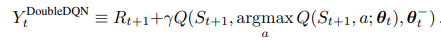

The weights of the second network contain the weights of the target network ***Θₜ-***for the evaluation of the current greedy policy. The update to the target network stays unchanged from
DQN, and remains a periodic copy of the online network[1].









In [ ]:
class MarioNet(nn.Module):
    """mini cnn structure
  input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
  """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim
       

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

        self.target = copy.deepcopy(self.online)

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

# TD Estimate & TD Target

Two values are involved in learning:
**TD Estimate** - the predicted optimal 𝑸* for a given state *s*

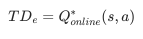

**TD Target** - aggregation of current reward and the estimated 𝑸* in the next state *s'* 


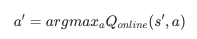

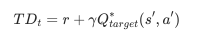

In [ ]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir, pretrained):
        super().__init__(state_dim, action_dim, save_dir, pretrained)
        self.gamma = 0.9
 
    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

# Updating Double DQN Model 

As Mario samples inputs from his replay buffer, we compute *TDₜ* and *TDₑ* and backpropagate this loss down Qₒₗᵢₙₑ to update its parameters *θₒₗᵢₙₑ* (α is the learning rate)  
​
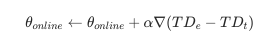

theta_target weights does not get updated during backpropogation, instead rather weights from online are assigned to the weights to the target
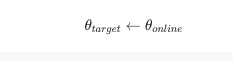


In [ ]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir, pretrained):
        super().__init__(state_dim, action_dim, save_dir, pretrained)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

# Training the Mario Agent!

Mario was trained for 10,000 episodes on the GPU and the Double DQN model weights were saved along with the exploration rate, and Mario's memory, which is a deque collecion of max lenghth 30000 of tuples containing:


1.   The state that Mario remembers when deciding on an action (ie., saved as LazyFrame object of four tensors)
2.   The next_state that Mario remembers after taking the ation (ie., saved as LazyFrame object of four tensors)
3.   The action Mario took from the action space (ie., int)
4.   The reward Mario recieved for his action (ie., float)
5.   And whether this combination of state, action, nextstate, and reward led to ending the game (i.e., done state)


---
# Key HyperParmaters: ✴

1. **self.burnin** : the count of frames (experiences) to add to memory/cache before starting training.
2. **self.learn_every** : the count of frames (expperiences) to add to memory/cace before updating the weights of the online DQN network
3. **self.sync_every** : indicates how frequently we sync model weights from the online DQN network to the target DQN network (i.e.how many frames in between syncing)








In [ ]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir, pretrained):
        super().__init__(state_dim, action_dim, save_dir, pretrained)
        self.burnin = 0  # min. experiences before training
        self.learn_every = 1  # no. of experiences between updates to Q_online
        self.sync_every = 100  # no. of experiences between Q_target & Q_online sync

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate
        td_est = self.td_estimate(state, action)

        # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

In [ ]:
def run(training_mode, pretrained, num_episodes=1):
  use_cuda = torch.cuda.is_available()
  print(f"Using CUDA: {use_cuda}")
  print()

  save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
  save_dir.mkdir(parents=True)
  mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir, pretrained=pretrained)

  
  total_rewards =[]
  for e in tqdm(range(num_episodes)):
    state = env.reset()
    total_reward = 0
    STATE = state
    ACTION = None
    REWARD = None
    NEXT_STATE = None
    DONE = None
    # Play the game!
    while True:
          # Renders to the display
          env.render()
          action = mario.act(state)
          # Agent performs action
          next_state, reward, done, info = env.step(action)
          total_reward += reward
          STATE = state
          ACTION = action
          REWARD = reward
          NEXT_STATE = next_state
          DONE = done
          if training_mode:
            # Remember
            mario.cache(state, next_state, action, reward, done)
            # Learn
            q, loss = mario.learn()
          # Update state
          state = next_state
          # Check if end of game
          if done or info["flag_get"]:
            break

    total_rewards.append(total_reward)
    if e != 0 and e % 100 == 0:
      print("Episode {} score = {}, average score = {}".format(e + 1, total_rewards[-1], np.mean(total_rewards)))

  print("Episode {} score = {}, average score = {}".format(e + 1, total_rewards[-1], np.mean(total_rewards)))
  
  if training_mode:
    #saving model weights
    torch.save(mario.net.state_dict(), "model.pth")
    #saving the exploration rate
    torch.save(mario.get_exploration_rate(), "exploration_rate.pth")
    # saving the memory queue
    torch.save(mario.get_memory(), "memory.pth")
  env.close()
  show_video()


In [ ]:
# # runing the game and then testing the game
# run(training_mode=True, pretrained=False, num_episodes=10000)

In [ ]:
# Training Mario for another 100 episodes to see if warm_staring Mario makes a difference
# with only the weights
run(training_mode=True, pretrained=True, num_episodes=100)

Using CUDA: True



100%|██████████| 100/100 [04:35<00:00,  2.76s/it]


Episode 100 score = 55, average score = 285.15


In [ ]:
# Testing Mario and gathering video of his performance over one episode
run(training_mode=False, pretrained=True, num_episodes=1)

Using CUDA: True



  0%|          | 0/1 [00:00<?, ?it/s]